In [1]:
import networkx as nx
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx

In [3]:
plt.rcParams["figure.figsize"] = (20,3)

In [4]:
from shared.schema import DatasetSchema, GraphSchema
from shared.graph import DataGraph, igraph_to_nx

from datasets.visualization import plot_explore_dual_histogram, show_top_k_nodes, show_top_k_stacked_nodes

In [5]:
DATASET = DatasetSchema.load_schema('enron-mail-20150507')
schema = GraphSchema.from_dataset(DATASET)
G = DataGraph.from_schema(schema)

In [6]:
TIMESTAMP_BINS = 50
K = 10
HAS_NODE_TIMESTAMP = schema.is_node_temporal()
HAS_EDGE_TIMESTAMP = schema.is_edge_temporal()
BETWEENESS_K = 1

print('Has node timestamp: {}'.format(HAS_NODE_TIMESTAMP))
print('Has edge timestamp: {}'.format(HAS_EDGE_TIMESTAMP))

Has node timestamp: True
Has edge timestamp: False


# Dataset Specific Statistics

## Visualize Distribution of Nodes over Time

In [7]:
NODE_TIMESTAMPS = pd.Series(G.vs['timestamp'], name='timestamp', index=G.vs['name']) if HAS_NODE_TIMESTAMP else None
EDGE_TIMESTAMPS = pd.Series(G.es['timestamp'], name='timestamp', index=range(G.ecount())) if HAS_EDGE_TIMESTAMP else None
LABELS = pd.Series(G.vs['label'], name='label', index=G.vs['name'])

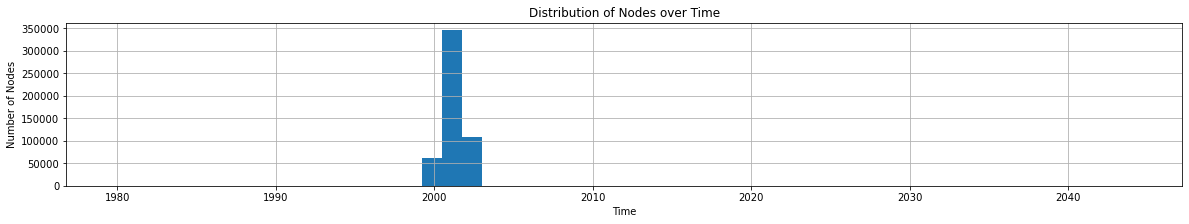

In [8]:
if HAS_NODE_TIMESTAMP:
    NODE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(NODE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Nodes over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Nodes')
else:
    print('No node timestamp data available')

In [9]:
if HAS_EDGE_TIMESTAMP:
    EDGE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(EDGE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Edges over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Edges')
else:
    print('No edge timestamp data available')

No edge timestamp data available


# Global Statistics

In [10]:
print(f'Number of Nodes: {G.vcount()}')
print(f'Number of Edges: {G.ecount()}')
print(f'Density: {G.density()}')

Number of Nodes: 605076
Number of Edges: 4179878
Density: 1.1416802002533399e-05


In [11]:
degrees = pd.Series(G.degree(), index=G.vs['name'])

In [12]:
print(f'Average Degree: {np.mean(degrees)}')
print(f'Median Degree: {np.median(degrees)}')

Average Degree: 13.816042943365792
Median Degree: 2.0


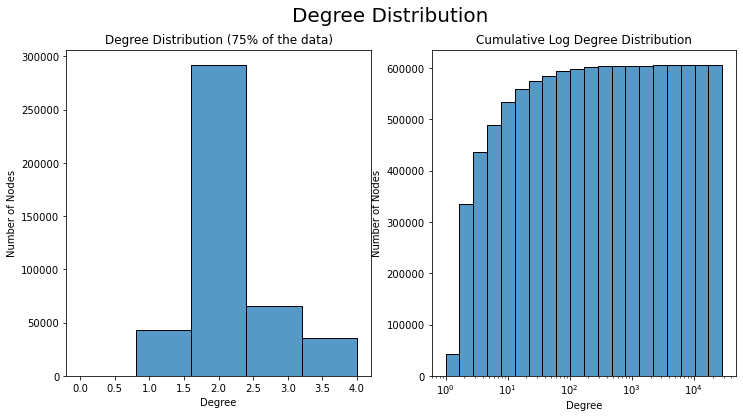

In [13]:
plot_explore_dual_histogram(
    series=degrees,
    title='Degree Distribution',
    title_short='Degree Distribution',
    xlabel='Degree',
    ylabel='Number of Nodes',
    normalize=False,
)
plt.show()

In [14]:
show_top_k_nodes(
    degrees,
    LABELS,
    title='Degree Nodes'
)

Top 10 Degree Nodes


,value,label
0,28568,jeff.dasovich@enron.com
1,27523,pete.davis@enron.com
2,26378,vince.kaminski@enron.com
3,24886,kay.mann@enron.com
4,23741,tana.jones@enron.com
5,22907,sara.shackleton@enron.com
6,22876,steven.kean@enron.com
7,20226,richard.shapiro@enron.com
8,17140,mark.taylor@enron.com
9,14374,james.steffes@enron.com


## Connectivity Metrics
* **degree_centrality**: Degree centrality of a node is the fraction of nodes it is connected to.
* **closeness_centrality**: Closeness centrality of a node is the inverse of the average shortest path length to all other nodes.
* **betweenness_centrality**: Betweenness centrality of a node is the fraction of all shortest paths in the network that pass through it.
* **eigenvector_centrality**: Eigenvector centrality of a node is the normalized sum of the eigenvector centralities of all its neighbors.
* **pagerank**: PageRank is a ranking of nodes based on the structure of the network.
* **transitivity**: Clustering coefficient is the fraction of triangles that are formed by a node and its neighbors.

In [15]:
# Use the largest connected component
G_cc = G.components("weak").giant()
G_cc.to_undirected()

# Convert to NetworkX
nx_G = igraph_to_nx(G_cc)
nx_Gu = nx.Graph(nx_G)

In [16]:
print('Average Clustering Coefficient: {}'.format(nx.approximation.average_clustering(nx_Gu)))
print('Diameter: {}'.format(nx.approximation.diameter(nx_Gu)))

Average Clustering Coefficient: 0.0
Diameter: 24


In [17]:
# Calculate the metrics
metrics_dict = {}

metrics_dict['degree_centrality'] = nx.degree_centrality(nx_G)
try:
    metrics_dict['betweenness_centrality'] = nx.betweenness_centrality(nx_Gu, k=BETWEENESS_K)
except Exception as e:
    print('Betweenness Centrality Error: {}'.format(e))
try:
    metrics_dict['eigenvector_centrality'] = nx.eigenvector_centrality(nx_Gu)
except Exception as e:
    print('Eigenvector Centrality Error: {}'.format(e))
metrics_dict['page_rank'] = nx.pagerank(nx_Gu)
metrics_dict['transitivity'] = dict(zip(G_cc.vs['name'], G_cc.transitivity_local_undirected()))

NODE_STATS = pd.DataFrame(metrics_dict)
NODE_STATS.describe()

Eigenvector Centrality Error: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')


,degree_centrality,betweenness_centrality,page_rank,transitivity
count,592983.000000,5.929830e+05,5.929830e+05,548584.0
mean,0.000023,6.889703e-06,1.686389e-06,0.0
std,0.000245,9.731616e-04,2.619228e-05,0.0
min,0.000002,0.000000e+00,2.688745e-07,0.0
25%,0.000003,0.000000e+00,4.575430e-07,0.0
50%,0.000003,9.064956e-11,5.740513e-07,0.0
75%,0.000008,1.027313e-07,7.732148e-07,0.0
max,0.047349,6.441018e-01,6.544692e-03,0.0


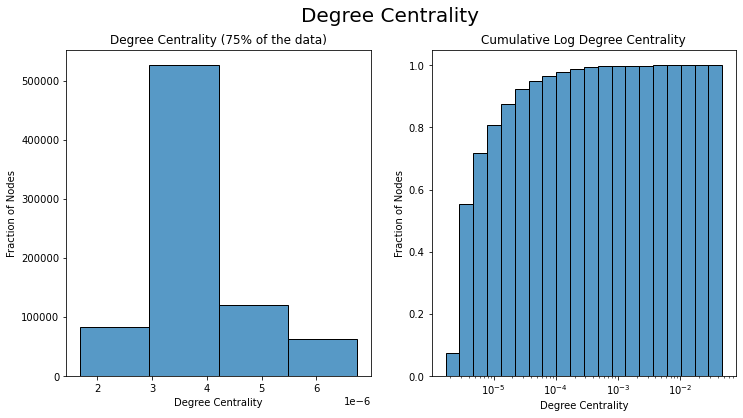

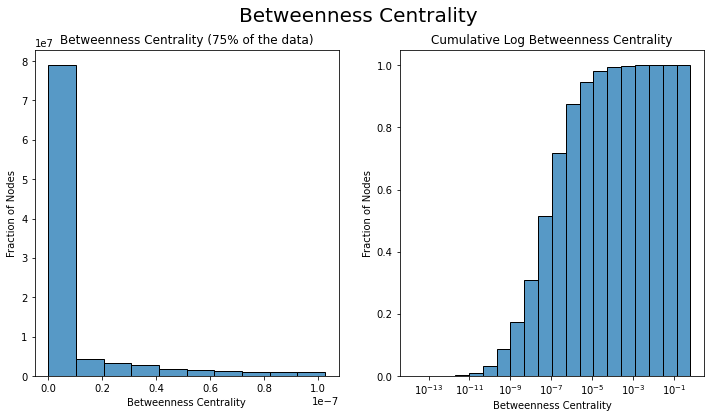

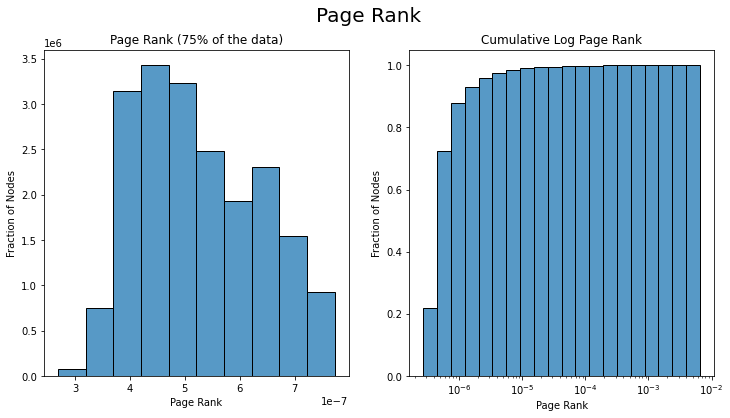

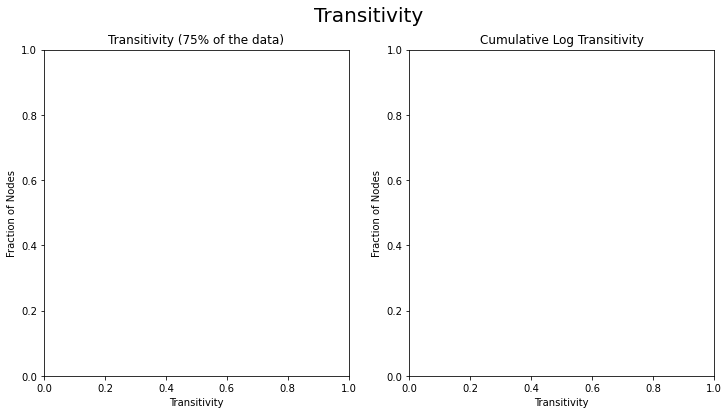

In [18]:
for col in NODE_STATS.columns:
    title = col.replace('_', ' ').title()
    data = NODE_STATS[col][np.isfinite(NODE_STATS[col])]
    try:
        plot_explore_dual_histogram(
            series=data,
            title=title,
            title_short=title,
            xlabel=title,
            ylabel='Fraction of Nodes',
            normalize=True,
        )
        plt.show()
    except:
        print(f'Failed to plot {title}')

In [19]:
show_top_k_stacked_nodes(
    NODE_STATS,
    LABELS,
    title='Nodes by Statistic',
)

Top 10 Nodes by Statistic


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.047349,jeff.dasovich@enron.com,0.644102,kimberly.watson@enron.com,0.006545,kay.mann@enron.com,0.0,/o=enron/ou=na/cn=recipients/cn=notesaddr/cn=a...
1,0.041507,kay.mann@enron.com,0.355898,tracy.geaccone@enron.com,0.006475,vince.kaminski@enron.com,0.0,Gov Aff Outcome
2,0.039986,tana.jones@enron.com,0.041547,Body Shop Pillar Construction Starts - June 10th,0.004847,sara.shackleton@enron.com,0.0,The message is spreading
3,0.038578,sara.shackleton@enron.com,0.041547,Body Shop Pillar Construction Starts - June 10th,0.004759,no.address@enron.com,0.0,IDEAS ON ELECTRICITY AND GAS ACTION PLAN
4,0.038436,steven.kean@enron.com,0.038045,vince.kaminski@enron.com,0.004539,tana.jones@enron.com,0.0,Wholesale Market Coverage - Eastern Interconne...
5,0.035782,vince.kaminski@enron.com,0.034162,jeff.dasovich@enron.com,0.004275,jeff.dasovich@enron.com,0.0,Re: FW: DA Account Balances
6,0.033950,richard.shapiro@enron.com,0.033771,steven.kean@enron.com,0.004264,enron.announcements@enron.com,0.0,QF situation good example of why price caps ma...
7,0.028691,mark.taylor@enron.com,0.031229,richard.shapiro@enron.com,0.003639,steven.kean@enron.com,0.0,Re: More Info: PG&E to Announce Open Season on...
8,0.024171,james.steffes@enron.com,0.026072,,0.003219,mark.taylor@enron.com,0.0,Price Caps creating blackouts in NV & CA
9,0.023328,chris.germany@enron.com,0.026072,,0.002892,chris.germany@enron.com,0.0,Re: BANKRUPTCY MESSAGING on Negative CTC


## Connected Components Statistics

In [20]:
print(f'Number of Connected Components: {len(G.components("weak"))}')
largest_cc = G.components("weak").giant()
print(f'Size of the largest component: {largest_cc.vcount()}')

Number of Connected Components: 1618
Size of the largest component: 592983


Text(0.5, 1.0, 'Connected Components')

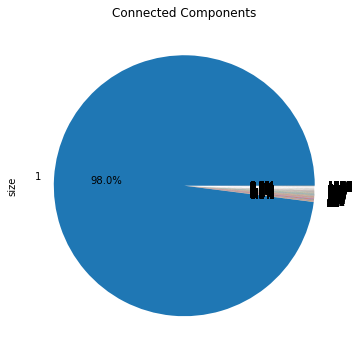

In [21]:
df_tmp = pd.DataFrame([{'size': len(c)} for i,c in enumerate(G.components("weak"))], index=range(1,len(G.components("weak"))+1))
ax = df_tmp.plot.pie(
    y='size',
    figsize=(6,6),
    autopct='%1.1f%%',
    legend=False,
)
ax.set_title('Connected Components')

# Type Specific Statistics

### Node Type Statistics

In [22]:
node_types = schema.get_node_types()
node_type_stats = pd.DataFrame([
    {
        'type': node_type,
        'count': len(G.vs.select(type=node_type)),
        'degree_avg': np.mean(G.vs.select(type=node_type).degree()),
        'degree_median': np.median(G.vs.select(type=node_type).degree()),
    }
    for node_type in node_types
], index=node_types)
print('Node Type count: {}'.format(len(node_types)))
node_type_stats

Node Type count: 2


,type,count,degree_avg,degree_median
Email,Email,517398,8.078651,2.0
User,User,87678,47.673054,3.0


<AxesSubplot:title={'center':'Node type counts'}, ylabel='count'>

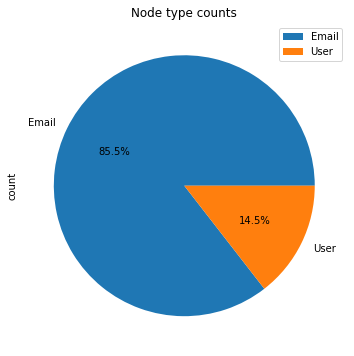

In [23]:
node_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Node type counts', figsize=(6,6))

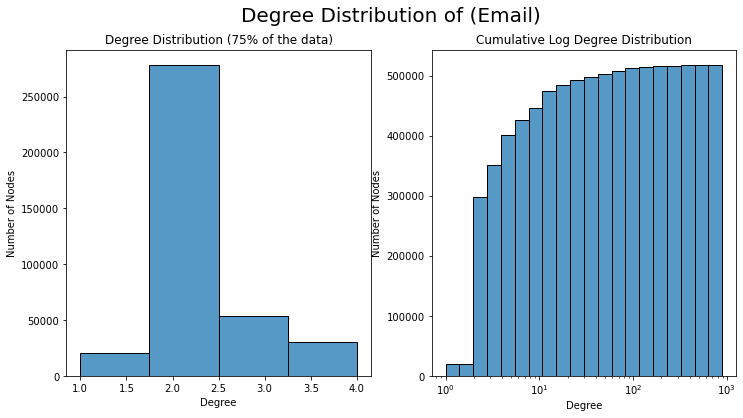

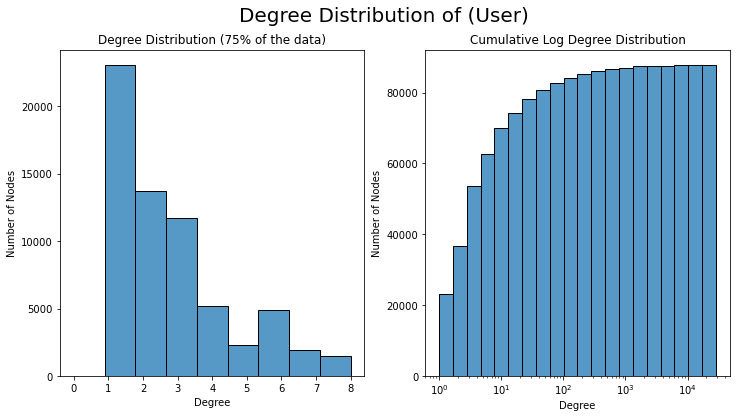

In [24]:
for node_type in node_types:
    degrees = pd.Series(G.vs.select(type=node_type).degree())
    plot_explore_dual_histogram(
        series=degrees,
        title=f'Degree Distribution of ({node_type})',
        title_short='Degree Distribution',
        xlabel='Degree',
        ylabel='Number of Nodes',
    )
    plt.show()

In [25]:
for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    data = pd.Series(nodes.degree(), index=nodes['name'])
    show_top_k_nodes(
        data,
        LABELS,
        title=f'Degree Nodes of Type ({node_type})'
    )

Top 10 Degree Nodes of Type (Email)


,value,label
0,892,Updated Cougars@Enron Email List
1,883,Associate/Analyst Program
2,883,Associate/Analyst Program
3,883,Associate/Analyst Program
4,883,Associate/Analyst Program
5,883,Associate/Analyst Program
6,883,Associate/Analyst Program
7,882,Associate/Analyst Program
8,882,Associate/Analyst Program
9,820,"Solar Migration - October 13-14, 2001 - Second..."


Top 10 Degree Nodes of Type (User)


,value,label
0,28568,jeff.dasovich@enron.com
1,27523,pete.davis@enron.com
2,26378,vince.kaminski@enron.com
3,24886,kay.mann@enron.com
4,23741,tana.jones@enron.com
5,22907,sara.shackleton@enron.com
6,22876,steven.kean@enron.com
7,20226,richard.shapiro@enron.com
8,17140,mark.taylor@enron.com
9,14374,james.steffes@enron.com


### Edge Type Statistics

In [26]:
edge_types = schema.get_edge_types()
edge_type_stats = pd.DataFrame([
    {
        'type': edge_type,
        'count': len(G.es.select(type=edge_type)),
    }
    for edge_type in edge_types
], index=edge_types)
print('Edge Type count: {}'.format(len(edge_types)))
edge_type_stats

Edge Type count: 3


,type,count
ADDRESSED_CC,ADDRESSED_CC,561305
ADDRESSED_TO,ADDRESSED_TO,3101175
SENT,SENT,517398


<AxesSubplot:title={'center':'Edge type counts'}, ylabel='count'>

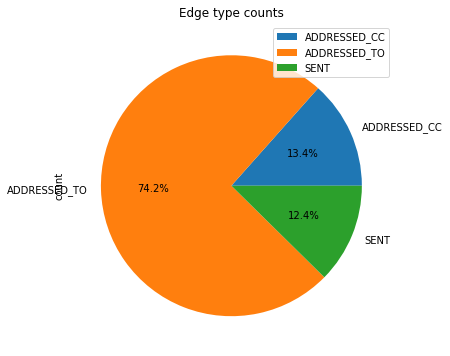

In [27]:
edge_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Edge type counts', figsize=(6,6))

## Node Type Connectivity Statistics

In [28]:
node_stats_by_type = {}

for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    names = set(nodes['name']) & set(NODE_STATS.index)

    node_stats_by_type[node_type] = NODE_STATS.loc[names]

In [29]:
for node_type in node_types:
    show_top_k_stacked_nodes(
        node_stats_by_type[node_type],
        LABELS,
        title=f'Nodes by Statistic for {node_type}',
    )

Top 10 Nodes by Statistic for Email


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.001503,Updated Cougars@Enron Email List,0.041547,Body Shop Pillar Construction Starts - June 10th,0.000421,Reminder and update for tomorrow's Roundtable,0.0,Re: Leadership meeting
1,0.001486,Associate/Analyst Program,0.041547,Body Shop Pillar Construction Starts - June 10th,0.000302,GasEDI Standard Contract,0.0,News article on Enron
2,0.001486,Associate/Analyst Program,0.026072,,0.000264,Doyle goes to Global Energy Markets (G.E.M.)!!,0.0,Re: Lunch?
3,0.001486,Associate/Analyst Program,0.026072,,0.000249,RE: Closing of ENNEC Department,0.0,Attached Files
4,0.001486,Associate/Analyst Program,0.026072,,0.000242,"Fw: WENH Membership ""Reminder Notice""",0.0,RE: UBS AG Market Based Rate Tariff Application
5,0.001486,Associate/Analyst Program,0.013771,"New Cash Conrol Process - 2:00 pm Meeting, Dec...",0.000241,Fall 2001 Football Update,0.0,Juniper/Petrocom GISB
6,0.001486,Associate/Analyst Program,0.009629,Flood Relief,0.000233,Email Address Change,0.0,Project Timber EOTT Accounting Memo
7,0.001484,Associate/Analyst Program,0.009006,CASH & REORG FINANCIAL REPORTING,0.000217,National Day of Prayer,0.0,FW: Estate Group List
8,0.001484,Associate/Analyst Program,0.008982,FW: CASH & REORG FINANCIAL REPORTING,0.000202,Legal Update,0.0,PAC RIM CLUB General Meeting & TRIP INFO SESSI...
9,0.001381,"Solar Migration - October 13-14, 2001 - Second...",0.007952,CASH & REORG FINANCIAL REPORTING -- 19 Month T...,0.000195,Maxwell Museum Update,0.0,Re: Maynard Oil - Revised Nom


Top 10 Nodes by Statistic for User


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.047349,jeff.dasovich@enron.com,0.644102,kimberly.watson@enron.com,0.006545,kay.mann@enron.com,0.0,e.bulletin@schwab.com
1,0.041507,kay.mann@enron.com,0.355898,tracy.geaccone@enron.com,0.006475,vince.kaminski@enron.com,0.0,margaret.kinsler@enron.com
2,0.039986,tana.jones@enron.com,0.038045,vince.kaminski@enron.com,0.004847,sara.shackleton@enron.com,0.0,gisb1@aol.com
3,0.038578,sara.shackleton@enron.com,0.034162,jeff.dasovich@enron.com,0.004759,no.address@enron.com,0.0,dg27@pacbell.net
4,0.038436,steven.kean@enron.com,0.033771,steven.kean@enron.com,0.004539,tana.jones@enron.com,0.0,offer@americanbranding.network60.com
5,0.035782,vince.kaminski@enron.com,0.031229,richard.shapiro@enron.com,0.004275,jeff.dasovich@enron.com,0.0,wwaltrip@na.cokecce.com
6,0.033950,richard.shapiro@enron.com,0.024558,kay.mann@enron.com,0.004264,enron.announcements@enron.com,0.0,e-mail <.titus@enron.com>
7,0.028691,mark.taylor@enron.com,0.024402,susan.scott@enron.com,0.003639,steven.kean@enron.com,0.0,gsmith@ruf.rice.edu
8,0.024171,james.steffes@enron.com,0.023832,shonnie.daniel@enron.com,0.003219,mark.taylor@enron.com,0.0,cmccabe@pacbell.net
9,0.023328,chris.germany@enron.com,0.020714,christi.nicolay@enron.com,0.002892,chris.germany@enron.com,0.0,kristin.passmore@enron.com


# Clustering

## No Clustering Modularity

In [30]:
n = G_cc.vcount()
print(f'Initial modularity: {G_cc.modularity(np.ones(n))}')

Initial modularity: 1.1102230246251565e-16


### Louvain

In [31]:
louvain = G_cc.community_multilevel()
print(f'Modularity after Louvain: {G_cc.modularity(louvain)}')
print(f'Number of communities: {len(louvain)}')

Modularity after Louvain: 0.7251525511807015
Number of communities: 277


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

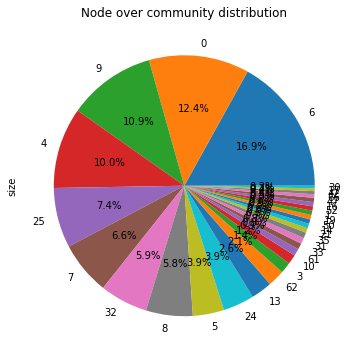

In [32]:
community_sizes = pd.Series(list(map(len, louvain)), name='size', index=range(len(louvain)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.023328,chris.germany@enron.com,0.018937,chris.germany@enron.com,0.002892,chris.germany@enron.com,0.0,#2.martin@enron.com
1,0.014918,matthew.lenhart@enron.com,0.008927,yuan.tian@enron.com,0.002253,matthew.lenhart@enron.com,0.0,Re: National Fuel Says They Are Pathed Model Type
2,0.012005,john.arnold@enron.com,0.007769,matthew.lenhart@enron.com,0.001556,john.arnold@enron.com,0.0,RE:
3,0.010606,scott.neal@enron.com,0.006238,RE: TWPL Imbalance,0.001008,mike.grigsby@enron.com,0.0,Re: CGAS
4,0.010403,mike.grigsby@enron.com,0.006238,RE: TWPL Imbalance,0.000991,scott.neal@enron.com,0.0,RE: Faith Hill
5,0.007206,errol.mclaughlin@enron.com,0.006238,RE: TWPL Imbalance,0.000802,errol.mclaughlin@enron.com,0.0,CES - Term Sell for Dayton Power Light on TCO ...
6,0.006337,barry.tycholiz@enron.com,0.006060,john.arnold@enron.com,0.000738,mike.maggi@enron.com,0.0,TRV Notification: (NG - PROPT P/L - 10/23/2001)
7,0.005997,kam.keiser@enron.com,0.005389,mike.grigsby@enron.com,0.000663,barry.tycholiz@enron.com,0.0,Allied Deals
8,0.005938,scott.goodell@enron.com,0.003389,kevin.ruscitti@enron.com,0.000639,john.griffith@enron.com,0.0,catch up
9,0.005713,mike.maggi@enron.com,0.003216,stephanie.miller@enron.com,0.000595,dutch.quigley@enron.com,0.0,FW: System Imbalance Notice


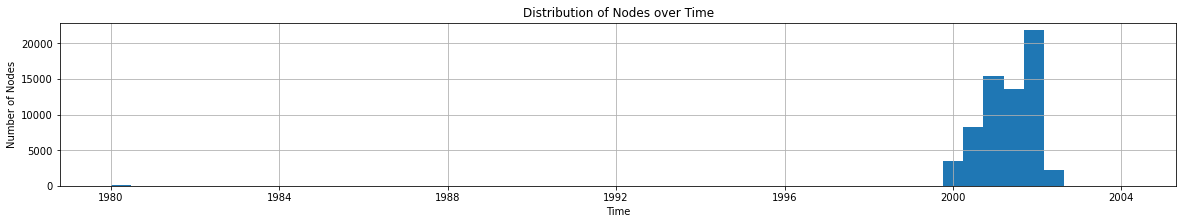

Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.001042,mark.e.haedicke@enron.com,0.002409,Tactical Allocation Fund--1st Quarter 2001,0.000241,Fall 2001 Football Update,0.0,'blanchard@enron.com
1,0.000442,Fall 2001 Football Update,0.002409,Tactical Allocation Fund--1st Quarter 2001,0.000123,mark.e.haedicke@enron.com,0.0,fmatti@bci.it
2,0.000432,rpickel@isda.org,0.001267,Kirk Barneby Conference Call,0.000066,FW: CDD,0.0,f.bataller@bbva.bancomer.com
3,0.000393,scarey@isda.org,0.001267,Kirk Barneby Conference Call,0.000066,FW: CDD,0.0,fabia.warlix@db.com
4,0.000366,FW: CDD,0.001246,mark.e.haedicke@enron.com,0.000048,gwhalle@enron.com,0.0,faprado@pinheironeto.com.br
5,0.000366,FW: CDD,0.000424,Fall 2001 Football Update,0.000046,mhaedic@ect.enron.com,0.0,fcaputo@bci.it
6,0.000312,Tactical Allocation Fund--1st Quarter 2001,0.000405,SDR Task Force Meeting - Email One,0.000045,eserver@enron.com,0.0,fcaputo@enron.com
7,0.000312,Tactical Allocation Fund--1st Quarter 2001,0.000265,FW: Delivery failure,0.000043,SDR Task Force Meeting - Email One,0.0,fcjacob@bnpparibasl.com.br
8,0.000305,rainslie@isda.org,0.000265,FW: Delivery failure,0.000042,scarey@isda.org,0.0,fhampton@bondmarkets.com
9,0.000290,mcunningham@isda.org,0.000166,sneal@enron.com,0.000037,rocky.emery@painewebber.com,0.0,fnolan@lehman.com


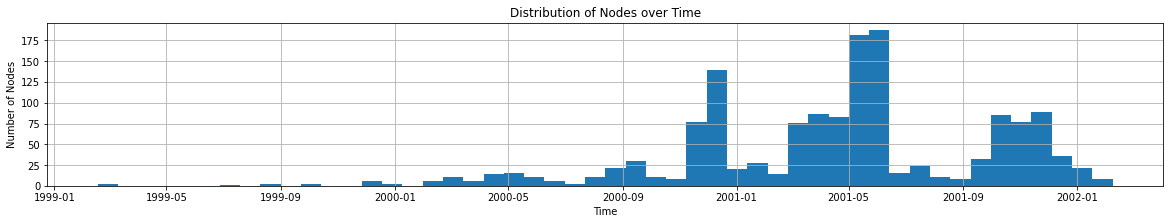

Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000175,FYI,0.000218,andrew.h.lewis@enron.com,0.000069,New Sae Page Alumni Section,0.0,'.''ann@enron.com
1,0.000175,FYI,0.000129,New Sae Page Alumni Section,0.000034,FYI,0.0,gail_rudloff@oxy.com
2,0.000175,FYI,0.000077,FW: Nudge your co-workers!,0.000034,FYI,0.0,jcyprow@enron.com
3,0.000123,New Sae Page Alumni Section,0.000077,FW: Nudge your co-workers!,0.000034,FYI,0.0,jcasti@coair.com
4,0.000116,tkuyken@enron.com,0.000077,FW: Nudge your co-workers!,0.000020,tkuyken@enron.com,0.0,jberglun@graland.org
5,0.000116,jennifer_lamprecht@oxy.com,0.000077,FW: Nudge your co-workers!,0.000017,jennifer_lamprecht@oxy.com,0.0,jayharlan99@yahoo.com
6,0.000103,susan.hadix@elpaso.com,0.000065,tkuyken@enron.com,0.000015,susan.hadix@elpaso.com,0.0,jason_devon@oxy.com
7,0.000076,FW: optical illusion,0.000054,FYI,0.000015,andrew.h.lewis@enron.com,0.0,jas10422@aol.com
8,0.000073,New Address and Phone Number,0.000054,FYI,0.000013,FW: optical illusion,0.0,janderson@hscsal.com
9,0.000073,New Address and Phone Number,0.000054,FYI,0.000013,You're Invited!,0.0,jam2115@aol.com


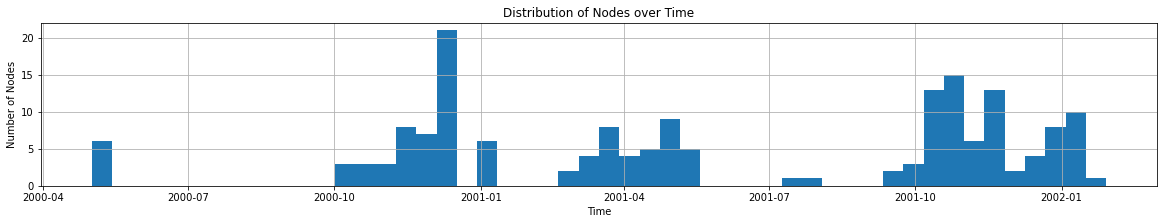

Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.006692,jdasovic@enron.com,0.003756,jdasovic@enron.com,0.000532,jdasovic@enron.com,0.0,'.'delaney@enron.com
1,0.002106,gtbl@dynegy.com,0.000868,mbaldwin@igservice.com,0.000103,richard.costigan@asm.ca.gov,0.0,daniel.collins@elpaso.com
2,0.001928,kmccrea@sablaw.com,0.000563,bwood@energy.state.ca.us,0.000074,Assembly Tax Suspense File,0.0,dana@ncpa.com
3,0.001599,sscott3@enron.com,0.000476,sscott3@enron.com,0.000074,Assembly Tax Suspense File,0.0,dana@gablegroup.com
4,0.001563,eke@aelaw.com,0.000233,richard.costigan@asm.ca.gov,0.000067,sscott3@enron.com,0.0,dan_predpall@urscorp.com
5,0.001479,cabaker@duke-energy.com,0.000217,Memorandum from Julie Simon,0.000055,venturewire@venturewire.com,0.0,dan_pigeon@transalta.com
6,0.001438,rick.counihan@greenmountain.com,0.000217,Memorandum from Julie Simon,0.000046,kmccrea@sablaw.com,0.0,dan_kostenbauder@hp.com
7,0.001408,jleslie@luce.com,0.000217,Memorandum from Julie Simon,0.000044,mbaldwin@igservice.com,0.0,dan_kirshner@environmentaldefense.org
8,0.001405,craigc@calpine.com,0.000211,Assembly Tax Suspense File,0.000042,CAISO Notice - Discretionary Load Curtailment ...,0.0,dan_kirshner@edf.org
9,0.001373,burkee@cts.com,0.000211,Assembly Tax Suspense File,0.000042,CAISO Notice - Discretionary Load Curtailment ...,0.0,dan@spp412.sppco.com


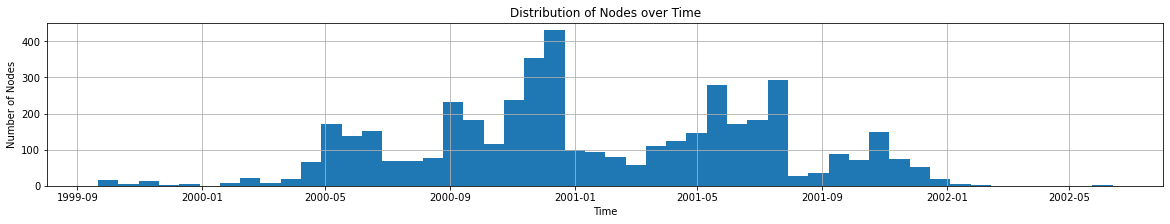

Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.047349,jeff.dasovich@enron.com,0.034162,jeff.dasovich@enron.com,0.004275,jeff.dasovich@enron.com,0.0,'.'@enron.com
1,0.038436,steven.kean@enron.com,0.033771,steven.kean@enron.com,0.003639,steven.kean@enron.com,0.0,NRG AFFILIATES ASK FERC TO RULE ON DISPUTED ST...
2,0.033950,richard.shapiro@enron.com,0.031229,richard.shapiro@enron.com,0.002392,richard.shapiro@enron.com,0.0,DWR floating position
3,0.024171,james.steffes@enron.com,0.020714,christi.nicolay@enron.com,0.001519,james.steffes@enron.com,0.0,EBS GA Conference Call
4,0.019481,susan.mara@enron.com,0.015749,mary.hain@enron.com,0.001366,richard.sanders@enron.com,0.0,Japan Website
5,0.017665,paul.kaufman@enron.com,0.015487,james.steffes@enron.com,0.001175,susan.mara@enron.com,0.0,Re: Portfolio Manager in CA - United Illuminat...
6,0.016122,tim.belden@enron.com,0.012568,susan.mara@enron.com,0.001022,paul.kaufman@enron.com,0.0,Ken Lay and Premier Harris
7,0.014628,richard.sanders@enron.com,0.011717,alan.comnes@enron.com,0.000959,tim.belden@enron.com,0.0,"Morning Market View for August 07, 2001"
8,0.013245,karen.denne@enron.com,0.010391,joe.hartsoe@enron.com,0.000948,phillip.allen@enron.com,0.0,CERA roundtable materials
9,0.012906,harry.kingerski@enron.com,0.009690,sarah.novosel@enron.com,0.000877,maureen.mcvicker@enron.com,0.0,Re: Assignment of Regulatory Risk Responsibili...


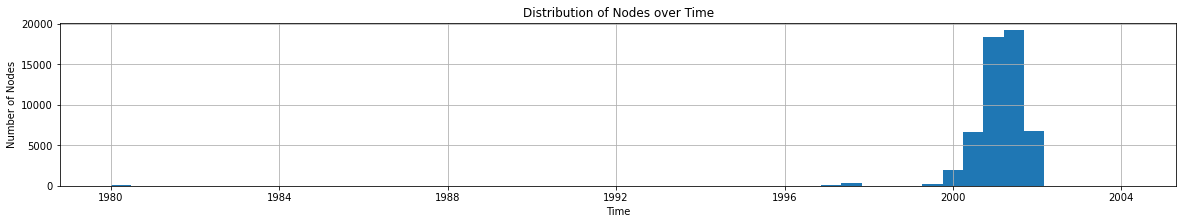

Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.014704,benjamin.rogers@enron.com,0.041547,Body Shop Pillar Construction Starts - June 10th,0.002028,benjamin.rogers@enron.com,0.0,'francis.hutchins'@enron.com
1,0.005380,robin.rodrigue@enron.com,0.041547,Body Shop Pillar Construction Starts - June 10th,0.000883,robin.rodrigue@enron.com,0.0,FW: NYISO revised
2,0.002828,don.miller@enron.com,0.026072,,0.000377,don.miller@enron.com,0.0,EES Volumetric Position
3,0.001875,gabriel.monroy@enron.com,0.026072,,0.000309,gabriel.monroy@enron.com,0.0,
4,0.001666,cooper.richey@enron.com,0.026072,,0.000233,Email Address Change,0.0,Avaya - Preparation Meeting EB4598A
5,0.001486,Associate/Analyst Program,0.009629,Flood Relief,0.000227,cooper.richey@enron.com,0.0,Docs update on DealBench
6,0.001486,Associate/Analyst Program,0.008941,benjamin.rogers@enron.com,0.000179,jinsung.myung@enron.com,0.0,Cross-sell opportunity
7,0.001486,Associate/Analyst Program,0.004660,robin.rodrigue@enron.com,0.000161,5K Freedom Run on Veteran's Day,0.0,Low Case Dispatch Analysis and Market Prices.
8,0.001486,Associate/Analyst Program,0.001264,Associate/Analyst Program,0.000157,rob.gay@enron.com,0.0,
9,0.001486,Associate/Analyst Program,0.001264,Associate/Analyst Program,0.000157,e.taylor@enron.com,0.0,Re:


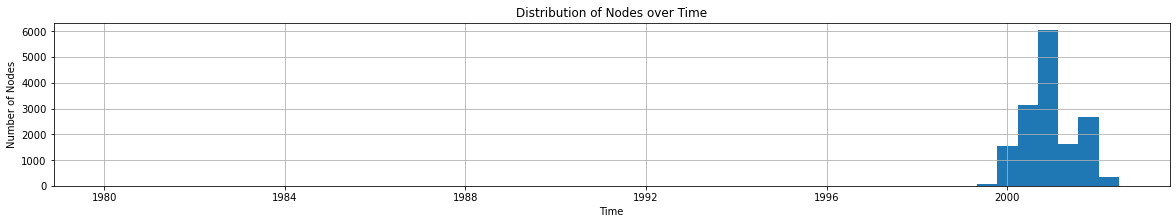

In [33]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(louvain))):
    # Show top k nodes
    community_node_names = names.loc[louvain[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )

    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No node timestamp data available')

### Label Propagation

In [34]:
label_prop = G_cc.community_label_propagation()
print(f'Modularity after Label Propagation: {G_cc.modularity(label_prop)}')
print(f'Number of communities: {len(label_prop)}')

Modularity after Label Propagation: 0.6480171348476216
Number of communities: 2084


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

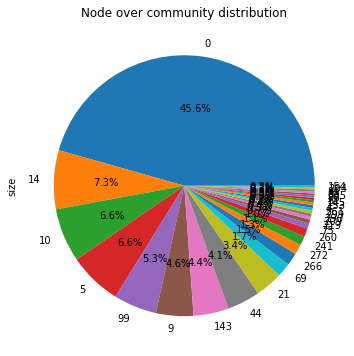

In [35]:
community_sizes = pd.Series(list(map(len, label_prop)), name='size', index=range(len(label_prop)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.039986,tana.jones@enron.com,0.041547,Body Shop Pillar Construction Starts - June 10th,0.004539,tana.jones@enron.com,0.0,#2.martin@enron.com
1,0.028691,mark.taylor@enron.com,0.041547,Body Shop Pillar Construction Starts - June 10th,0.003219,mark.taylor@enron.com,0.0,Gray Davis
2,0.023328,chris.germany@enron.com,0.026072,,0.002892,chris.germany@enron.com,0.0,FW: palo alto
3,0.022616,sally.beck@enron.com,0.026072,,0.002547,gerald.nemec@enron.com,0.0,Re: Entex Transport Reimbursement
4,0.019673,gerald.nemec@enron.com,0.026072,,0.002402,sally.beck@enron.com,0.0,
5,0.018899,louise.kitchen@enron.com,0.023832,shonnie.daniel@enron.com,0.002253,matthew.lenhart@enron.com,0.0,ESA
6,0.018660,john.lavorato@enron.com,0.019761,sally.beck@enron.com,0.001935,eric.bass@enron.com,0.0,RE:
7,0.016183,daren.farmer@enron.com,0.018937,chris.germany@enron.com,0.001784,louise.kitchen@enron.com,0.0,Sunday the 14th
8,0.014918,matthew.lenhart@enron.com,0.015281,tana.jones@enron.com,0.001763,john.lavorato@enron.com,0.0,Energycast
9,0.013869,eric.bass@enron.com,0.015072,gerald.nemec@enron.com,0.001740,daren.farmer@enron.com,0.0,Tony's PGL deals


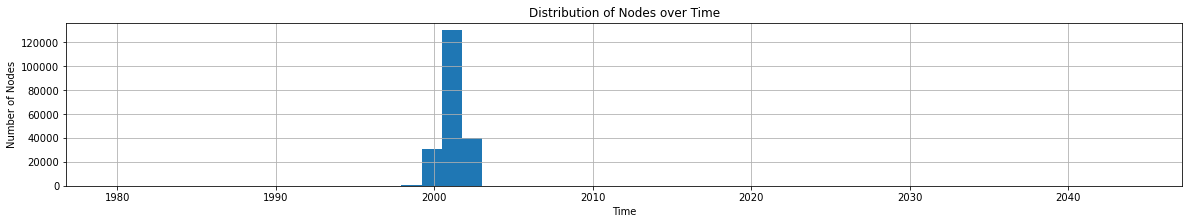

Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000081,Friday Meetings on Netting Provisions - Details,5.403738e-05,Bankruptcy Letters & Conference Call Tomorrow ...,0.000012,Friday Meetings on Netting Provisions - Details,0.0,'blanchard@enron.com
1,0.000081,Meetings on Netting Provisions,1.096158e-05,Friday Meetings on Netting Provisions - Details,0.000012,Meetings on Netting Provisions,0.0,michael.nelson@ny.frb.org
2,0.000076,Netting Legislation Conference Call - 2:30 p.m...,7.588789e-06,Meetings on Netting Provisions,0.000011,Netting Legislation Conference Call - 2:30 p.m...,0.0,jparet@sia.com
3,0.000066,Bankruptcy Letters & Conference Call Tomorrow ...,5.059193e-06,Netting Legislation Conference Call - 2:30 p.m...,0.000009,Bankruptcy Letters & Conference Call Tomorrow ...,0.0,jstorrs@sia.com
4,0.000019,BANKRUPTCY CONFERENCE CALL TODAY AT 2:00 p.m.,1.073217e-06,strupp_cory@jpmorgan.com,0.000002,BANKRUPTCY CONFERENCE CALL TODAY AT 2:00 p.m.,0.0,jthibau@exchange.ml.com
5,0.000015,fhampton@bondmarkets.com,6.097432e-07,BANKRUPTCY CONFERENCE CALL TODAY AT 2:00 p.m.,0.000002,fhampton@bondmarkets.com,0.0,jvogt@bondmarkets.com
6,0.000012,strupp_cory@jpmorgan.com,3.577334e-07,loneill@bear.com,0.000001,jvogt@bondmarkets.com,0.0,kmckechn@aba.com
7,0.000012,jvogt@bondmarkets.com,1.078394e-12,fhampton@bondmarkets.com,0.000001,strupp_cory@jpmorgan.com,0.0,lawrence.brandman@gs.com
8,0.000008,loneill@bear.com,9.269468e-13,jvogt@bondmarkets.com,0.000001,"Conference Call - Friday, November 9, 2001",0.0,levyr@citi.com
9,0.000008,joseph.seidel@csfb.com,8.255920e-13,lawrence.brandman@gs.com,0.000001,"Conference Call - Friday, November 9, 2001",0.0,loneill@bear.com


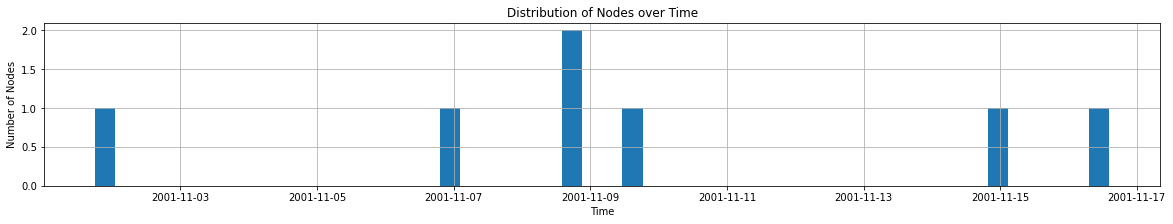

Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000042,RE: FERC To Examine Alleged Market Manipulatio...,0.000034,RE: FERC To Examine Alleged Market Manipulatio...,1.063788e-05,RE: FERC To Examine Alleged Market Manipulatio...,0.0,'.''ann@enron.com
1,0.000042,RE: FERC To Examine Alleged Market Manipulatio...,0.000034,RE: FERC To Examine Alleged Market Manipulatio...,1.063788e-05,RE: FERC To Examine Alleged Market Manipulatio...,0.0,'.''karen@enron.com
2,0.000007,'.'phil@enron.com,0.000029,'.'mike@enron.com,1.109647e-06,'.'mike@enron.com,0.0,RE: FERC To Examine Alleged Market Manipulatio...
3,0.000005,'.'mike@enron.com,0.000000,'.''karen@enron.com,8.994954e-07,'.'phil@enron.com,0.0,'.'tom@enron.com
4,0.000003,'.''karen@enron.com,0.000000,'.'tom@enron.com,7.139956e-07,'.''karen@enron.com,0.0,'.'phil@enron.com
5,0.000003,'.'tom@enron.com,0.000000,'.'phil@enron.com,7.139956e-07,'.'tom@enron.com,0.0,'.'mike@enron.com
6,0.000003,'.''robert@enron.com,0.000000,'.''robert@enron.com,7.139956e-07,'.''robert@enron.com,0.0,'.''robert@enron.com
7,0.000003,'.''mike@enron.com,0.000000,'.''mike@enron.com,7.139956e-07,'.''mike@enron.com,0.0,'.''mike@enron.com
8,0.000003,'.''marc@enron.com,0.000000,'.''marc@enron.com,7.139956e-07,'.''marc@enron.com,0.0,'.''marc@enron.com
9,0.000003,'.''linda@enron.com,0.000000,'.''linda@enron.com,7.139956e-07,'.''linda@enron.com,0.0,'.''linda@enron.com


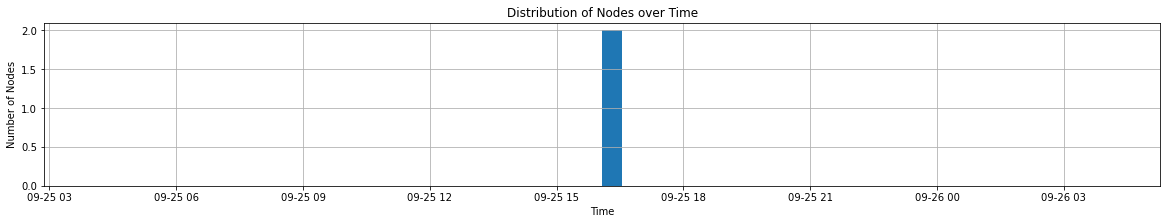

Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000005,RE:,0.000003,RE:,2.633254e-06,RE:,0.0,RE:
1,0.000002,'.''matthew@enron.com,0.000000,'.''matthew@enron.com,8.254517e-07,'.''matthew@enron.com,NaN,'.''matthew@enron.com
2,0.000002,'.'truong@enron.com,0.000000,'.'truong@enron.com,8.254517e-07,'.'truong@enron.com,NaN,'.'truong@enron.com


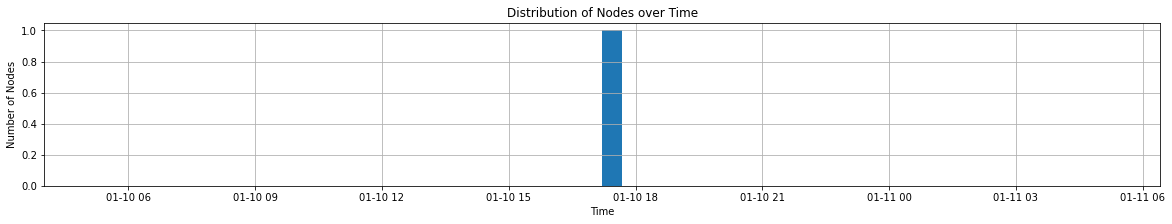

Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.001928,kmccrea@sablaw.com,0.000563,bwood@energy.state.ca.us,0.000067,sscott3@enron.com,0.0,'.'delaney@enron.com
1,0.001599,sscott3@enron.com,0.000476,sscott3@enron.com,0.000046,kmccrea@sablaw.com,0.0,afm@cpuc.ca.gov
2,0.001563,eke@aelaw.com,0.000099,Consent To Assignment,0.000035,vjw@cleanpower.org,0.0,anna.ferrera@sen.ca.gov
3,0.001438,rick.counihan@greenmountain.com,0.000096,kmccrea@sablaw.com,0.000035,eke@aelaw.com,0.0,ann.cohn@sce.com
4,0.001408,jleslie@luce.com,0.000095,sschleimer@calpine.com,0.000034,dhunter@s-k-w.com,0.0,andy.bettwy@swgas.com
5,0.001327,rmp@cpuc.ca.gov,0.000064,R.99-10-025,0.000029,rick.counihan@greenmountain.com,0.0,andy.bettwy@groupwise.swgas.com
6,0.001282,gsullivan@sempra.com,0.000064,R.99-10-025,0.000026,drothrock@cmta.net,0.0,am1@cpuc.ca.gov
7,0.001162,johnj@bcjlaw.com,0.000058,skatz@sempratrading.com,0.000025,brbarkovich@earthlink.net,0.0,alippin@mail.arco.com
8,0.001157,mdjoseph@adamsbroadwell.com,0.000045,karen@klindh.com,0.000025,jleslie@luce.com,0.0,albergor@haynesboone.com
9,0.001153,plg@cpuc.ca.gov,0.000044,napedersen@jonesday.com,0.000025,gsullivan@sempra.com,0.0,alb@cpuc.ca.gov


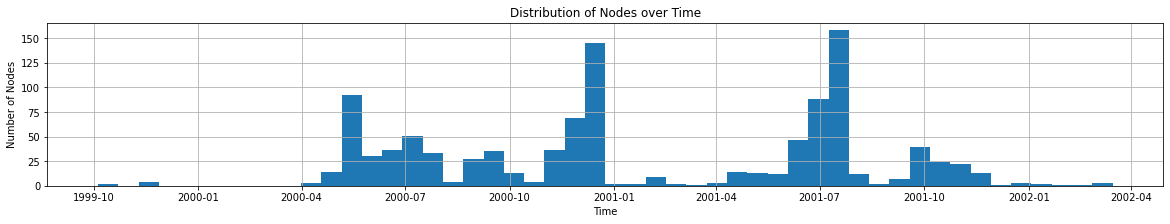

Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.047349,jeff.dasovich@enron.com,0.034162,jeff.dasovich@enron.com,0.004275,jeff.dasovich@enron.com,0.0,'.'@enron.com
1,0.033950,richard.shapiro@enron.com,0.031229,richard.shapiro@enron.com,0.002392,richard.shapiro@enron.com,0.0,Conversation with Edison re: Getting Negative ...
2,0.024171,james.steffes@enron.com,0.015749,mary.hain@enron.com,0.001519,james.steffes@enron.com,0.0,FW: A.98-07-003 et al. JOINT PROPOSAL OF THE U...
3,0.019481,susan.mara@enron.com,0.015487,james.steffes@enron.com,0.001366,richard.sanders@enron.com,0.0,RE: California Update--10.02.01:Part 2: PUC A...
4,0.017665,paul.kaufman@enron.com,0.012568,susan.mara@enron.com,0.001175,susan.mara@enron.com,0.0,RE: SCE Stipulation
5,0.016122,tim.belden@enron.com,0.011717,alan.comnes@enron.com,0.001022,paul.kaufman@enron.com,0.0,Re: FW: Natole
6,0.014628,richard.sanders@enron.com,0.010391,joe.hartsoe@enron.com,0.000959,tim.belden@enron.com,0.0,FW: Green Power Partners
7,0.013245,karen.denne@enron.com,0.009690,sarah.novosel@enron.com,0.000835,karen.denne@enron.com,0.0,California Litigation Team - Conference Call o...
8,0.012906,harry.kingerski@enron.com,0.005392,mike.smith@enron.com,0.000711,mary.hain@enron.com,0.0,"Part 4, revised"
9,0.012476,joe.hartsoe@enron.com,0.005032,richard.sanders@enron.com,0.000680,harry.kingerski@enron.com,0.0,Legislation to Change Make-up of Governing Boards


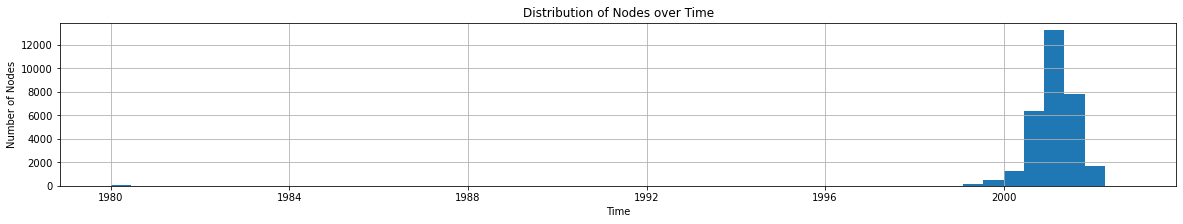

In [36]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(label_prop))):
    # Show top k nodes
    community_node_names = names.loc[label_prop[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )


    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No timestamp data available')